In [1]:
import tensorflow as tf
import numpy as np
import glob
from scipy import misc 
import matplotlib.pyplot as plt
%matplotlib inline

tf_keras = tf.contrib.keras

In [6]:
# load pre-trained VGG model and exclude top dense layers
base_model = tf_keras.applications.VGG16(include_top=False,
                                         weights='imagenet',
                                         input_shape=(150, 150, 3))

In [7]:
def fine_tune_VGG(base_model):
    
     # output of convolutional layers
    net = base_model.output    
    
    # flatten/reshape layer
    net = tf_keras.layers.Flatten(
        input_shape=base_model.output_shape[1:])(net)

    # fully connected layer
    net = tf_keras.layers.Dense(256, activation=tf.nn.relu)(net)
    
    # dropout layer
    net = tf_keras.layers.Dropout(0.5)(net)

    # final Dense layer with binary classification
    outputs = tf_keras.layers.Dense(1, activation=tf.nn.sigmoid)(net)

    # define model with base_model's input
    model = tf_keras.models.Model(inputs=base_model.input, outputs=outputs)
    
    # freeze weights of conv blocks 1-4 (15 layers)
    # fine-tune last conv block and dense layers
    for layer in model.layers[:15]:
        layer.trainable = False
    
    return model

def compile_model(model):

    # SGD/optimizer (very slow learning rate)
    optimizer = tf_keras.optimizers.SGD(lr=1e-4, momentum=0.9)

    # compile the model with loss, optimizer and evaluation metrics
    model.compile(loss = tf_keras.losses.binary_crossentropy,
                  optimizer = optimizer,
                  metrics = [tf_keras.metrics.binary_accuracy])

    print(model.summary())
    
    return model

In [8]:
model = fine_tune_VGG(base_model)
model = compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [9]:
batch_size = 16
train_data_dir = "../data/training"
test_data_dir = "../data/testing"
# 25000 images
train_size = 20000
test_size = 5000
input_shape = (150, 150, 3)
batch_size = 32
# prepare data augmentation configuration
train_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [10]:
# fine-tune the model
history = model.fit_generator(
        train_generator,
        steps_per_epoch= 5, #train_size // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps= 10) #test_size // batch_size)

Epoch 1/5
5/5 [==============================] - 251s 50s/step - loss: 0.8258 - binary_accuracy: 0.5312 - val_loss: 0.7209 - val_binary_accuracy: 0.4969
Epoch 2/5
5/5 [==============================] - 235s 47s/step - loss: 0.7277 - binary_accuracy: 0.5062 - val_loss: 0.6590 - val_binary_accuracy: 0.6188
Epoch 3/5
5/5 [==============================] - 236s 47s/step - loss: 0.6721 - binary_accuracy: 0.5750 - val_loss: 0.6742 - val_binary_accuracy: 0.5594
Epoch 4/5
5/5 [==============================] - 235s 47s/step - loss: 0.8109 - binary_accuracy: 0.4688 - val_loss: 0.6451 - val_binary_accuracy: 0.6188
Epoch 5/5
5/5 [==============================] - 239s 48s/step - loss: 0.6984 - binary_accuracy: 0.6063 - val_loss: 0.6146 - val_binary_accuracy: 0.7063


In [11]:
# evaluate the model on batches with real-time data augmentation
loss, acc= model.evaluate_generator(validation_generator, steps = 10)
print("loss: {}".format(loss))
print("accuracy: {}".format(acc))

loss: 0.61460428834
accuracy: 0.70625


In [13]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('vgg accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('vgg loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

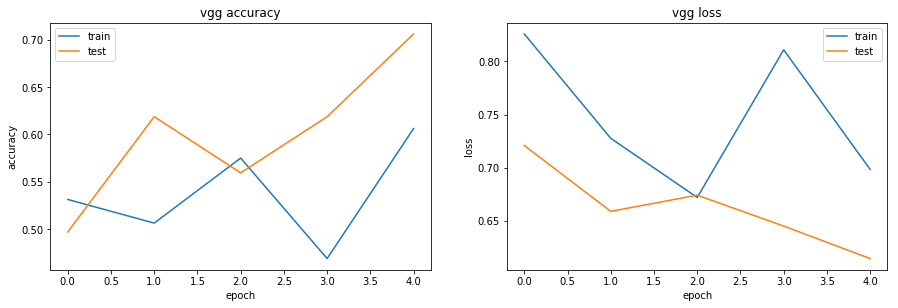

In [14]:
plot_accuracy_and_loss(history)

In [15]:
#save model
model_json = model.to_json()
open('cat_and_dog_fine_tune_model.json', 'w').write(model_json)
model.save_weights('image_classifier_cat_and_dog_fine_tune_.h5',
                   overwrite=True)